In [5]:
#!conda install -y -c conda-forge pyarrow

In [43]:
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
import dask.dataframe as dd
import pandas as pd
import re

%matplotlib inline
%config Completer.use_jedi = False

**Set parameters**

In [44]:
plt.rcParams["axes.labelweight"] = "bold"

sns.set_palette("deep")
sns.set_style("white")
sns.set_context("paper", font_scale = 2.0, rc={"grid.linewidth": 2.5, 'fontweight':'bold'})

**Load GPU failures**

In [45]:
FAILURES = '/gpfs/alpine/stf218/proj-shared/data/lake/summit_gpu_failures/gpu_failures.csv'
NODE = 'hostname'
TIME = 'timestamp'
XID = 'xid'

failures = pd.read_csv(FAILURES)[[NODE, XID]]

In [46]:
# Remove data for login and batch nodes.
failures = failures[~failures[NODE].str.startswith('login') & ~failures[NODE].str.startswith('batch')]
failures[failures[NODE].str.startswith('login') | failures[NODE].str.startswith('batch')][NODE].unique()

array([], dtype=object)

In [47]:
xid_names = {
    31: 'Memory page fault', 13: 'Graphics engine exception', 43: 'Stopped processing', 74: 'NVLINK error',
    63: 'Page retirement event', 64: 'Page retirement failure', 48: 'Double-bit error', 45: 'Preemptive cleanup',
    61: 'Internal microcontroller warning', 44: 'Graphics engine fault', 79: 'Fallen off the bus', 62: 'Internal microcontroller halt',
    38: 'Driver firmware error', 32: 'Corrupted push buffer stream', 12: 'Driver error handling exception', 69: 'Graphics engine class error'}


In [49]:
failures['name'] = failures[XID].apply(xid_names.get)

In [52]:
len(failures)

251859

In [51]:
failures.groupby('name')[XID].count()

name
Corrupted push buffer stream            11
Double-bit error                       179
Driver error handling exception         21
Driver firmware error                   26
Fallen off the bus                      31
Graphics engine class error              1
Graphics engine exception            32339
Graphics engine fault                   44
Internal microcontroller halt           29
Internal microcontroller warning        74
Memory page fault                   186496
NVLINK error                          8736
Page retirement event                  851
Page retirement failure                210
Preemptive cleanup                     162
Stopped processing                   22649
Name: xid, dtype: int64

**Obtain failure frequencies in nodes**

In [15]:
FREQ = 'freq'
FAILURE = 'failure'

freq_per_node = failures.groupby([XID, NODE], as_index=False).size().rename(columns={'size': FREQ, XID: FAILURE})
freq_per_node[FAILURE] = freq_per_node[FAILURE].apply(xid_names.get)
freq_per_node.head()

,failure,hostname,freq
0,Driver error handling exception,e26n13,21
1,Graphics engine exception,a01n01,20
2,Graphics engine exception,a01n02,11
3,Graphics engine exception,a01n03,4
4,Graphics engine exception,a01n04,7


In [26]:
xid_counts = failures.groupby(XID)[XID].count()
xids = [xid_names[xid] for xid in xid_counts[xid_counts >= 20].index.values]

In [16]:
freq_per_node.groupby(FAILURE)[FREQ].sum().sort_values()

failure
Graphics engine class error              1
Corrupted push buffer stream            11
Driver error handling exception         21
Driver firmware error                   26
Internal microcontroller halt           29
Fallen off the bus                      31
Graphics engine fault                   44
Internal microcontroller warning        74
Preemptive cleanup                     162
Double-bit error                       179
Page retirement failure                210
Page retirement event                  851
NVLINK error                          8736
Stopped processing                   22649
Graphics engine exception            32339
Memory page fault                   186496
Name: freq, dtype: int64

In [27]:
xid_freqs = freq_per_node.pivot(index=NODE, columns=FAILURE, values=FREQ)
xid_freqs = freq_per_node[freq_per_node[FAILURE].isin(xids)].pivot(index=NODE, columns=FAILURE, values=FREQ)

In [28]:
xid_freqs = xid_freqs.fillna(0)

In [29]:
corrs = xid_freqs.corr(method='pearson')
is_na = corrs.isna().all(axis=0)
corrs = corrs[~is_na][corrs.columns[~is_na]]

**Plots**

In [39]:
import scipy.spatial.distance as dist
import scipy.stats as ss

p_values = dist.squareform(dist.pdist(xid_freqs.T, lambda x, y: ss.pearsonr(x, y)[1]))
p_values.shape
is_significant = p_values < 0.05 / 13 / 14

In [40]:
captions = np.empty_like(corrs, dtype=np.dtype('U4'))
captions[is_significant] = np.vectorize(lambda corr: f'{corr:.2f}'.replace('.' + '00', '').replace('0.', '.').replace('-0', '0'))(corrs)[is_significant]

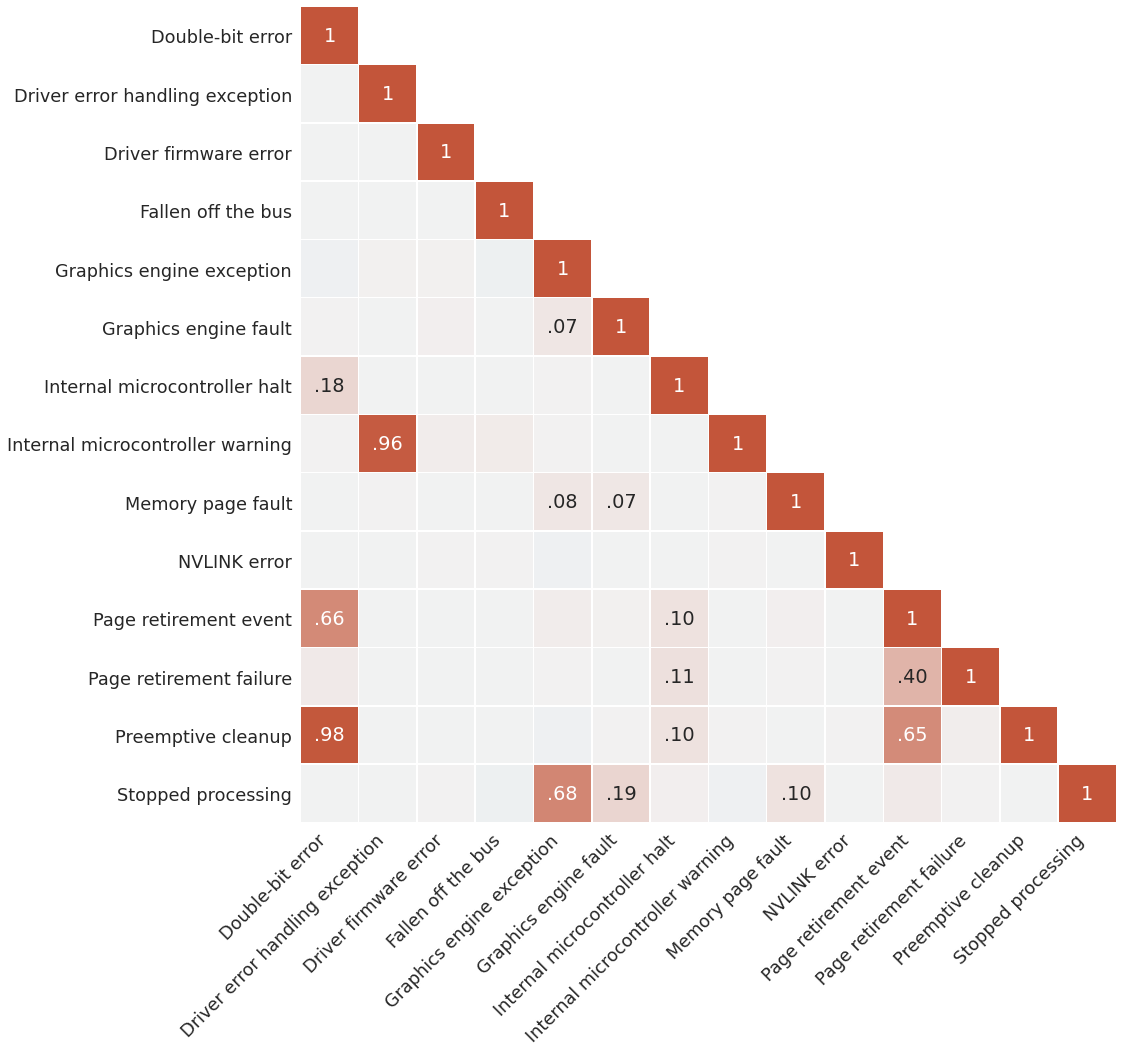

In [42]:
fig = plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corrs, dtype=bool), k=1)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax = sns.heatmap(corrs, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5,
                 annot=captions, fmt='', cbar_kws={"shrink": .8}, cbar=False)
ax.set_xlabel('')
ax.set_ylabel('')
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
fig.savefig(f'../plots/gpu_failure_corr.pdf')